<a href="https://colab.research.google.com/github/abhinavclemson/Face-Denoising/blob/master/Face%20denoise%20pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as tvF
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from sys import platform
from random import choice
from string import ascii_letters
import os
import scipy
import random
import cv2

class NoisyDataset(Dataset):
    
    def __init__(self, root_dir, crop_size=128, train_noise_model=('gaussian', 50), clean_targ=False):
        """
        root_dir: Path of image directory
        crop_size: Crop image to given size
        clean_targ: Use clean targets for training
        """
        self.root_dir = root_dir
        self.crop_size = crop_size
        self.clean_targ = clean_targ
        self.noise = train_noise_model[0]
        self.noise_param = train_noise_model[1]
        self.imgs = os.listdir(root_dir)

    
    def _random_crop_to_size(self, imgs):
        
        w, h = imgs[0].size
        assert w >= self.crop_size and h >= self.crop_size, 'Cannot be croppped. Invalid size'
        

        cropped_imgs = []
        i = np.random.randint(0, h - self.crop_size + 2)
        j = np.random.randint(0, w - self.crop_size + 2)

        for img in imgs:
            if min(w, h) < self.crop_size:
                img = tvF.resize(img, (self.crop_size, self.crop_size))
            cropped_imgs.append(tvF.crop(img, i, j, self.crop_size, self.crop_size))
        
        #cropped_imgs = cv2.resize(np.array(imgs[0]), (self.crop_size, self.crop_size))
        return cropped_imgs
    
    def _add_gaussian_noise(self, image):
        """
        Added only gaussian noise
        """
        w, h = image.size
        c = len(image.getbands())
        
        std = np.random.uniform(0, self.noise_param)
        _n = np.random.normal(0, std, (h, w, c))
        noisy_image = np.array(image) + _n
        
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
        return {'image':Image.fromarray(noisy_image), 'mask': None, 'use_mask': False}

    def _add_poisson_noise(self, image):
        """
        Added poisson Noise
        """
        noise_mask = np.random.poisson(np.array(image))
        #print(noise_mask.dtype)
        #print(noise_mask)
        return {'image':noise_mask.astype(np.uint8), 'mask': None, 'use_mask': False}

    def _add_m_bernoulli_noise(self, image):
        """
        Multiplicative bernoulli
        """
        sz = np.array(image).shape[0]
        prob_ = random.uniform(0, self.noise_param)
        mask = np.random.choice([0, 1], size=(sz, sz), p=[prob_, 1 - prob_])
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        return {'image':np.multiply(image, mask).astype(np.uint8), 'mask':mask.astype(np.uint8), 'use_mask': True}


    def _add_text_overlay(self, image):
        """
        Add text overlay to image
        """
        assert self.noise_param < 1, 'Text parameter should be probability of occupancy'

        w, h = image.size
        c = len(image.getbands())

        if platform == 'linux':
            serif = '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf'
        else:
            serif = 'Times New Roman.ttf'

        text_img = image.copy()
        text_draw = ImageDraw.Draw(text_img)
        mask_img = Image.new('1', (w, h))
        mask_draw = ImageDraw.Draw(mask_img)

        max_occupancy = np.random.uniform(0, self.noise_param)

        def get_occupancy(x):
            y = np.array(x, np.uint8)
            return np.sum(y) / y.size

        while 1:
            font = ImageFont.truetype(serif, np.random.randint(16, 21))
            length = np.random.randint(10, 25)
            chars = ''.join(choice(ascii_letters) for i in range(length))
            color = tuple(np.random.randint(0, 255, c))
            pos = (np.random.randint(0, w), np.random.randint(0, h))
            text_draw.text(pos, chars, color, font=font)

            # Update mask and check occupancy
            mask_draw.text(pos, chars, 1, font=font)
            if get_occupancy(mask_img) > max_occupancy:
                break
        
        return {'image':text_img, 'mask':None, 'use_mask': False}

    def corrupt_image(self, image):
        
        if self.noise == 'gaussian':
            return self._add_gaussian_noise(image)
        elif self.noise == 'poisson':
            return self._add_poisson_noise(image)
        elif self.noise == 'multiplicative_bernoulli':
            return self._add_m_bernoulli_noise(image)
        elif self.noise == 'text':
            return self._add_text_overlay(image)
        else:
            raise ValueError('No such image corruption supported')

    def __getitem__(self, index):
        """
        Read a image, corrupt it and return it
        """
        img_path = os.path.join(self.root_dir, self.imgs[index])
        image = Image.open(img_path).convert('RGB')

        if self.crop_size > 0:
            image = self._random_crop_to_size([image])[0]

        source_img_dict = self.corrupt_image(image)
        source_img_dict['image'] = tvF.to_tensor(source_img_dict['image'])

        if source_img_dict['use_mask']:
            source_img_dict['mask'] = tvF.to_tensor(source_img_dict['mask'])

        if self.clean_targ:
            #print('clean target')
            target = tvF.to_tensor(image)
        else:
            #print('corrupt target')
            _target_dict = self.corrupt_image(image)
            target = tvF.to_tensor(_target_dict['image'])

        if source_img_dict['use_mask']:
            return [source_img_dict['image'], source_img_dict['mask'], target]
        else:
            return [source_img_dict['image'], target]

    def __len__(self):
        return len(self.imgs)




import torch 
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    
    def __init__(self, ni, no, ks, stride=1, pad=1, use_act=True):
        
        super(ConvBlock, self).__init__()
        self.use_act = use_act
        self.conv = nn.Conv2d(ni, no, ks, stride=stride, padding=pad)
        self.bn = nn.BatchNorm2d(no)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        op = self.bn(self.conv(x))
        return self.act(op) if self.use_act else op


class ResBlock(nn.Module):
    
    def __init__(self, ni, no, ks):
        super(ResBlock, self).__init__()
        self.block1 = ConvBlock(ni, no, ks)
        self.block2 = ConvBlock(ni, no, ks, use_act=False)

    def forward(self, x):
        return x + self.block2(self.block1(x))
    

class SRResnet(nn.Module):

    def __init__(self, input_channels, output_channels, res_layers=16):
        super(SRResnet, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1)
        self.act = nn.LeakyReLU(0.2, inplace=True)

        _resl = [ResBlock(output_channels, output_channels, 3) for i in range(res_layers)]
        self.resl = nn.Sequential(*_resl)

        self.conv2 = ConvBlock(output_channels, output_channels, 3, use_act=False)
        self.conv3 = nn.Conv2d(output_channels, input_channels, kernel_size=3, stride=1, padding=1)
    
    def forward(self, input):
        _op1 = self.act(self.conv1(input))
        _op2 = self.conv2(self.resl(_op1))
        op = self.conv3(torch.add(_op1, _op2))
        return op



import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import DataLoader


class Train:
    
    def __init__(self, architecture, train_dir, val_dir, params):
        
        self.cuda = params['cuda']
        if self.cuda:
            self.architecture = architecture.cuda()
        else:
            self.architecture = architecture
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.noise_model = params['noise_model']
        self.crop_size = params['crop_size']
        self.clean_targs = params['clean_targs']
        self.lr = params['lr']
        self.epochs = params['epochs']
        self.bs = params['bs']
        

        self.train_dl, self.val_dl = self.__getdataset__()
        self.optimizer = self.__getoptimizer__()
        self.scheduler = self.__getscheduler__()
        self.loss_fn = self.__getlossfn__(params['lossfn'])

    
    def train(self):
        
        for _ in range(self.epochs):
            tr_loss = 0
            self.architecture.train()
            for _list in tqdm(self.train_dl):
                if self.cuda:
                    source = _list[0].cuda()
                    target = _list[-1].cuda()
                else:
                    source = _list[0]
                    target = _list[-1]
                _op = self.architecture(Variable(source))
                if len(_list) == 4:
                    if self.cuda:
                        mask = Variable(_list[1].cuda())
                    else:
                        mask = Variable(_list[1])
                    _loss = self.loss_fn(mask * _op, mask * Variable(target))
                else:
                    _loss = self.loss_fn(_op, Variable(target))
                tr_loss += _loss.data

                self.optimizer.zero_grad()
                _loss.backward()
                self.optimizer.step()
            
            val_loss = self.evaluate()
            #self.scheduler.step(val_loss)
            print(f'Training loss = {tr_loss}, Validation loss = {val_loss}')


    def evaluate(self):
        
        val_loss = 0
        self.architecture.eval()

        for _, _list in enumerate(self.val_dl):
            if self.cuda:
                source = _list[0].cuda()
                target = _list[-1].cuda()
            else:
                source = _list[0]
                target = _list[-1]
            _op = self.architecture(Variable(source))
            if len(_list) == 4:
                if self.cuda:
                    mask = Variable(_list[1].cuda())
                else:
                    mask = Variable(_list[1])
                _loss = self.loss_fn(mask * _op, mask * Variable(target))
            else:
                _loss = self.loss_fn(_op, Variable(target))
            val_loss += _loss.data
        
        return val_loss

    
    def __getdataset__(self):
        
        train_ds = NoisyDataset(self.train_dir, crop_size=self.crop_size, train_noise_model=self.noise_model,
                                        clean_targ=self.clean_targs)
        train_dl = DataLoader(train_ds, batch_size=self.bs, shuffle=True)

        val_ds = NoisyDataset(self.val_dir, crop_size=self.crop_size, train_noise_model=self.noise_model,
                                        clean_targ=True)
        val_dl = DataLoader(val_ds, batch_size=self.bs)

        return train_dl, val_dl

    def __getoptimizer__(self):
        
        return optim.Adam(self.architecture.parameters(), self.lr)

    def __getscheduler__(self):
        
        return lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=self.epochs/4, factor=0.5, verbose=True)

    def __getlossfn__(self, lossfn):
        
        if lossfn == 'l2':
            return nn.MSELoss()
        elif lossfn == 'l1':
            return nn.L1Loss()
        else:
            raise ValueError('No such loss function supported')

architecture = SRResnet(3, 64)

params = {
    'noise_model': ('poisson', None),
    'crop_size': 64,
    'clean_targs': False,
    'lr': 0.005,
    'epochs': 10,
    'bs': 32,
    'lossfn': 'l2',
    'cuda': True
}



In [0]:
data_ = NoisyDataset('drive/My Drive/Colab Notebooks/file dataset/noisy_large', crop_size=128) # Default gaussian noise without clean targets


<Figure size 432x288 with 0 Axes>

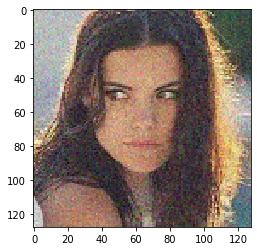

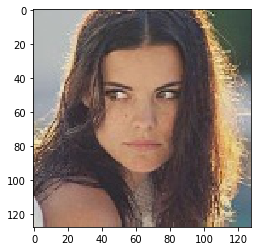

In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np

dl = DataLoader(data_, batch_size=1, shuffle=True)
def show(img):
    plt.figure()
    npimg = torch.squeeze(img).numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

i = 0
for d in dl:
    plt.figure()
    show(d[0])
    show(d[-1])
    if i == 0:
        break

In [0]:

trainer = Train(architecture, 'drive/My Drive/Colab Notebooks/file dataset/clean_large', 'drive/My Drive/Colab Notebooks/file dataset/clean_small', params)


In [38]:
trainer.train()

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss = 0.4987122118473053, Validation loss = 9.702714920043945
Training loss = 1.6538702249526978, Validation loss = 48900.5546875


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]

Training loss = 1.6429634094238281, Validation loss = 7567645.5
Training loss = 0.8372154831886292, Validation loss = 1574743.125



100%|██████████| 1/1 [00:00<00:00, 12.55it/s]

Training loss = 0.38857755064964294, Validation loss = 187662.96875
Training loss = 0.11643801629543304, Validation loss = 227506.890625



  0%|          | 0/1 [00:00<?, ?it/s]

Training loss = 0.24434807896614075, Validation loss = 45473.96484375
Training loss = 0.13542123138904572, Validation loss = 4661.1865234375


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]

Training loss = 0.08429765701293945, Validation loss = 1451.2669677734375
Training loss = 0.14948035776615143, Validation loss = 614.1114501953125


In [0]:
m = trainer.architecture

In [0]:
data_ = NoisyDataset('drive/My Drive/Colab Notebooks/Data noise/valid', crop_size=128, clean_targ=True) # Default gaussian noise without clean targets

In [0]:
dl = DataLoader(data_, batch_size=1, shuffle=True)
def show(img, a):
    plt.figure()
    if a == 'v':
        npimg = torch.squeeze(img).data.cpu().numpy()
    else:
        npimg = torch.squeeze(img).numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

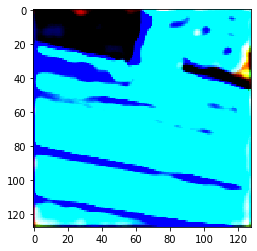

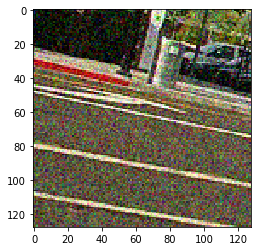

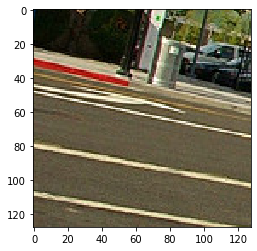

In [45]:
import matplotlib.pyplot as plt

i = 0
for _list in dl:
    plt.figure()
    pred = m(Variable(_list[0].cuda()))
    show(pred, 'v')
    show(_list[0], 't')
    show(_list[-1], 't')
    if i == 0:
        break

In [0]:
def pgm_normalize(image_array):
            '''
            pgm_normalize module reads the 2-D array and scale the values of the given array between 0-255
            and returns the array in 8 bit unsigned integer type
            '''
            old_max=image_array.max() #maximum value in input array
            old_min=image_array.min() #minimum value in input array
            old_range=old_max - old_min #range of values of input array

            new_min=0.0 #target minimum
            new_max=255.0 #target maximum
            new_range=new_max - new_min # target range
            


            for i in range(1,height-1):
                    for j in range(1,width-1):
                            old_val= image_array[i][j]
                            scale=(old_val-old_min)/old_range
                            
                            new_val=(new_range*scale)+new_min
                            image_array[i][j]= int(new_val) #converting the scaled value between 0.0 and 255.0 into integer type
                            
            image_array = image_array.astype(np.uint8)
            return image_array
 

In [47]:
pred.shape

torch.Size([1, 3, 128, 128])